In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Force network to output values in double format
tf.keras.backend.set_floatx('float64')

In [3]:
# Define the number of sigmoid activations in the hidden layer
H = 20

model = keras.Sequential([
    # 1 input -> H hidden sigmoids -> 1 linear output
    layers.Dense(units = H, activation = 'tanh', input_shape = (1,), kernel_initializer='glorot_normal'),
    layers.Dense(units = H, activation = 'tanh', kernel_initializer='glorot_normal'),
    layers.Dense(units = H, activation = 'tanh', kernel_initializer='glorot_normal'),
    layers.Dense(units = H, activation = 'tanh', kernel_initializer='glorot_normal'),
    layers.Dense(units = H, activation = 'tanh', kernel_initializer='glorot_normal'),
    layers.Dense(units = 1, activation = 'linear', use_bias = False)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 20        
                                                                 
Total params: 1,740
Trainable params: 1,740
Non-trainabl

In [4]:
# Endpoints a and b
# N + 2 grid points in total (including a and b)
a = 0
b = 8
N = 200
h = (b - a)/(N + 1)

# x holds the grid points to be used as input data
x = []
for i in range(N + 2):
    x.append(a + i*h)
    
# Remake the input data as a numpy array with shape = (N+2,1)
input_data = np.array(x)
input_data = input_data.reshape(202,1)

In [5]:
def trainStep(x,opt):
    
    # Outer GradientTape for derivatives wrt model parameters
    with tf.GradientTape() as tape:
        
        # Middle GradientTape for first derivative of N wrt x
        with tf.GradientTape() as tape1:
            tape1.watch(x)
            
            # Inner GradientTape for second derivative of N wrt x
            with tf.GradientTape() as tape2:
                tape2.watch(x)
            
                N = model([x])
            
            Nx = tape2.gradient(N, x)
        Nxx = tape1.gradient(Nx, x)
        
        # Plug trial solution into ODE:
        A = np.sin(3*np.pi/20)*np.cos(np.pi/10)+2
        B = np.sin(24*np.pi+3*np.pi/20)*np.cos(16*np.pi+np.pi/10)+2

        eqn = (-2*N+(16-4*x)*Nx+x*(8-x)*Nxx-4*(A*(8-x)/8+B*x/8+x*(8-x)*N)
              +(13*np.pi**2+4)*np.sin(3*np.pi*x+3*np.pi/20)*np.cos(2*np.pi*x+np.pi/10)
              +12*np.pi**2*np.cos(3*np.pi*x+3*np.pi/20)*np.sin(2*np.pi*x+np.pi/10)+8)
        
        loss = tf.reduce_sum(tf.square(eqn))
        
    # Compute the gradient of loss wrt model parameters
    grads = tape.gradient(loss, model.trainable_variables)
    
    # Gradient step
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [6]:
def PINNtrain(x, epochs):
    
    # Define an optimizer
    #lr = tf.keras.optimizers.schedules.PolynomialDecay(1e-2, epochs, 1e-3)
    #lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([10000,30000],[1e-2,1e-3,1e-4])
    opt = keras.optimizers.Adam(learning_rate = 0.001)
    epoch_loss = np.zeros(epochs)
    
    input_data = np.column_stack([x]).astype(np.float64)
    
    batch_size = 202
    data_sample = tf.data.Dataset.from_tensor_slices(input_data)
    data_sample = data_sample.cache().shuffle(202).batch(batch_size)
    
    ds = tf.data.Dataset.zip((data_sample))
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    # Main training loop
    for i in range(epochs):
        
        for j in ds:
            
            PDEloss = trainStep(j,opt)
            epoch_loss[i] += PDEloss

        if np.mod(i, 100)==0 or i == 99999:
          print("PDE loss in {}th epoch: {: 1.4e}.".format(i, epoch_loss[i]))
    
    return epoch_loss

In [7]:
epochs = 100000
loss = PINNtrain(input_data,epochs)

PDE loss in 0th epoch:  1.6530e+06.
PDE loss in 100th epoch:  1.5346e+06.
PDE loss in 200th epoch:  1.3915e+06.
PDE loss in 300th epoch:  1.3314e+06.
PDE loss in 400th epoch:  1.2764e+06.
PDE loss in 500th epoch:  1.2132e+06.
PDE loss in 600th epoch:  1.1794e+06.
PDE loss in 700th epoch:  1.1507e+06.
PDE loss in 800th epoch:  1.1051e+06.
PDE loss in 900th epoch:  1.0754e+06.
PDE loss in 1000th epoch:  1.0591e+06.
PDE loss in 1100th epoch:  1.0555e+06.
PDE loss in 1200th epoch:  1.0682e+06.
PDE loss in 1300th epoch:  9.9804e+05.
PDE loss in 1400th epoch:  9.8667e+05.
PDE loss in 1500th epoch:  9.8063e+05.
PDE loss in 1600th epoch:  9.6402e+05.
PDE loss in 1700th epoch:  9.5151e+05.
PDE loss in 1800th epoch:  9.0041e+05.
PDE loss in 1900th epoch:  8.7131e+05.
PDE loss in 2000th epoch:  8.6140e+05.
PDE loss in 2100th epoch:  9.0254e+05.
PDE loss in 2200th epoch:  8.3739e+05.
PDE loss in 2300th epoch:  8.2361e+05.
PDE loss in 2400th epoch:  8.2110e+05.
PDE loss in 2500th epoch:  8.3889e+05

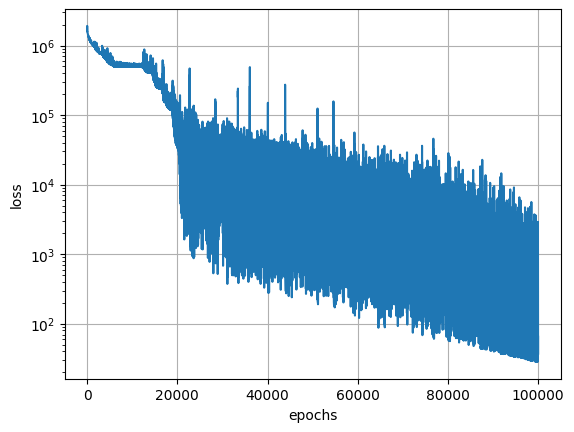

In [8]:
plt.semilogy(range(0, epochs), loss)
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.savefig('PINN_M=800_N=802_loss',dpi=300)
plt.grid()
plt.show()

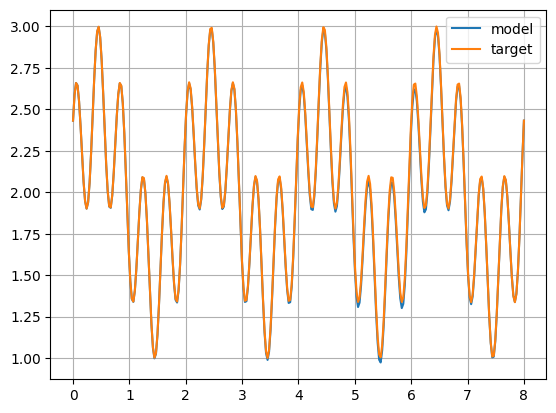

In [12]:
x = np.linspace(0,8,300)
target = []

for i in range(300): 
    target.append(np.sin(3*np.pi*x[i]+3*np.pi/20)*np.cos(2*np.pi*x[i]+np.pi/10)+2) 

A = np.sin(3*np.pi/20)*np.cos(np.pi/10)+2
B = np.sin(24*np.pi+3*np.pi/20)*np.cos(16*np.pi+np.pi/10)+2

plt.plot(x,A*(8-x)/8+B*x/8+x*(8-x)*model([x]).numpy().T[0], label = 'model')
plt.plot(x,target, label = 'target')
plt.legend()
plt.grid()
plt.savefig('PINN_M=20,L=10_2_plot',dpi=300)
plt.show()

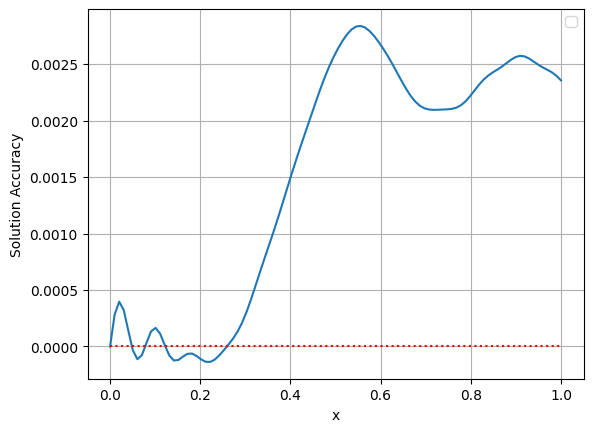

In [11]:
x = np.linspace(0,1,100)
target = []

for i in range(100): 
    target.append(np.sin(3*np.pi*x[i]+3*np.pi/20)*np.cos(2*np.pi*x[i]+np.pi/10)+2)

plt.plot(x,target-(A*(8-x)/8+B*x/8+x*(8-x)*model([x]).numpy().T[0]))
plt.plot(x,[0]*100, ':r')
plt.ylabel('Solution Accuracy')
plt.xlabel('x')
plt.legend(loc = 'upper right')
plt.grid()
plt.savefig('PINN_M=20_L=10_error',dpi=300)
plt.show()